<a href="https://colab.research.google.com/github/Hwagu/Colab/blob/main/EVpoly_LPR_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')

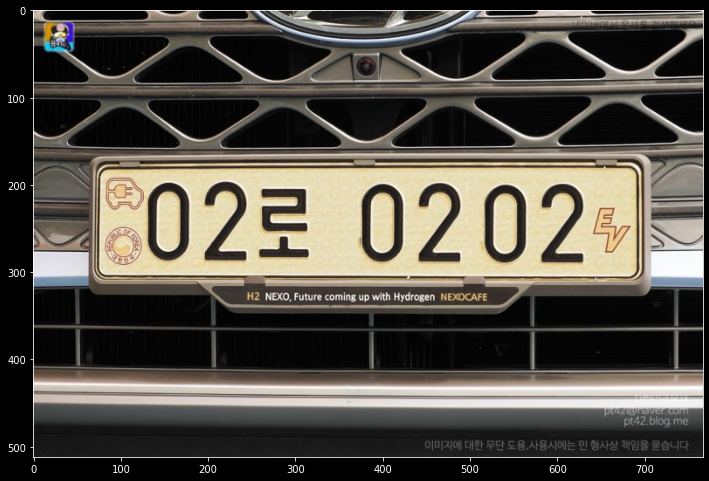

In [ ]:
# Read Input Image

img_ori = cv2.imread('/content/4.jpg') # openCV에서 이미지 로드

height, width, channel = img_ori.shape # 이미지의 너비, 높이, 채널을 저장

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

# 새 섹션

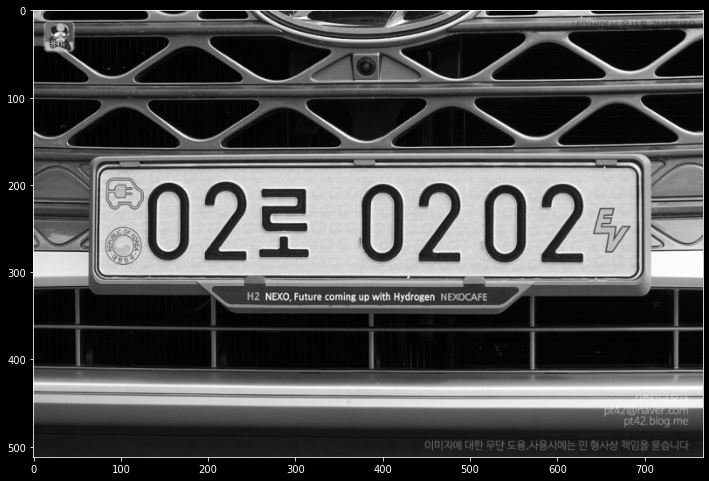

In [ ]:
# Convert Image to Grayscale

# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV) # BGR을 HSV 채널로 바꿔서 
# gray = hsv[:,:,2]                              # HSV의 V 채널만 사용 가능
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY) # openCV의 convertColor를 사용하여 BGR을 Gray로 바꿈
                                                 # Grayscale을 쓸 수 도 있고

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

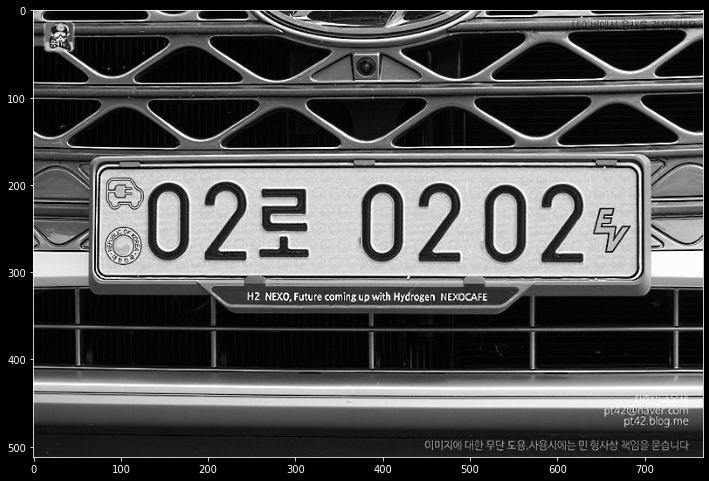

In [ ]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

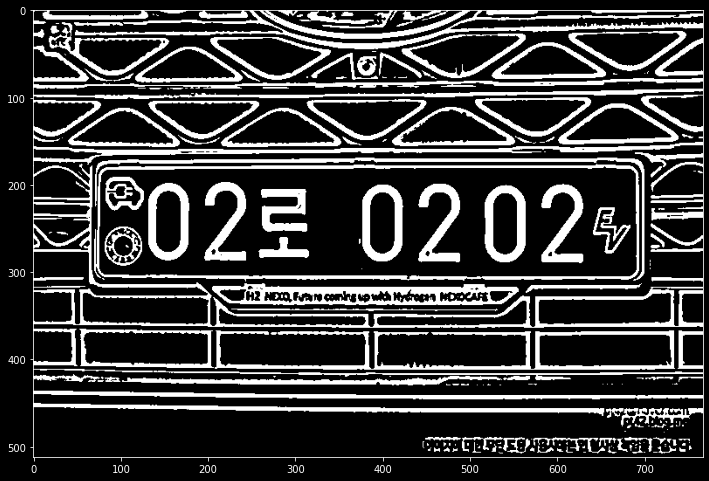

In [ ]:
# Adaptive Thresholding

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) # GaussianBlur 노이즈를 줄이기 위함
                                                             # 이미지에 존재하는 약간의 노이즈들을 없앰

img_thresh = cv2.adaptiveThreshold(                 # adaptiveThreshold
                                                    # 이미지에 Threshold를 지정
                                                    # 이미지 픽셀값을 Threshold보다 낮은 값은 0, 
                                                    # 높은 값은 255로 지정 -> 이미지를 구별하기 쉽게
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

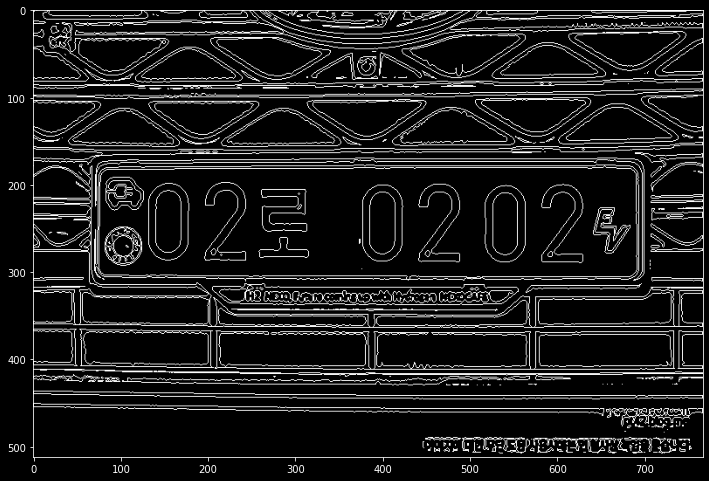

In [ ]:
# Find Contours

contours, _ = cv2.findContours(                  # findContours 이미지에서 윤곽선 찾기
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))
# drawContours 윤곽선 그리기, [contours=contours]는 컨투어 그리
# [contourIdx=-1]는 전체 contours를 그림

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

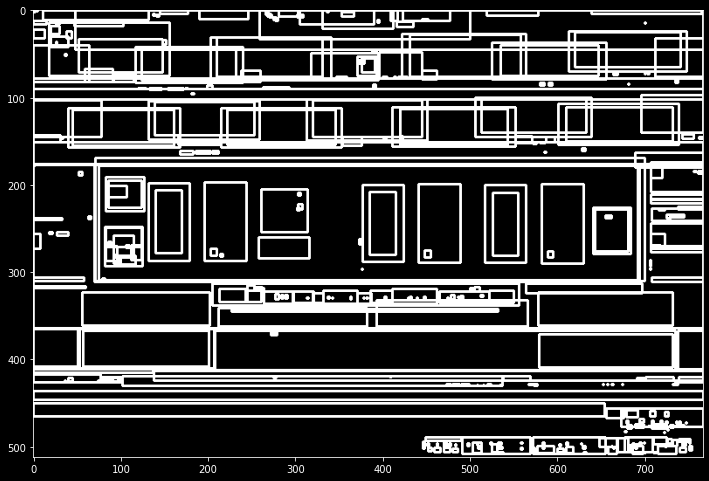

In [ ]:
# Prepare Data

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []     # list

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)   # boundingRect 윤곽선을 감싸는 사각형을 구함
                                             # x, y,너비, 높이 저장
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    # rectangle 이미지에 사각형을 그림, contours의 bounding rect 를 그림
    
    # insert to dict
    contours_dict.append({     
        # list에 contour와 각 x, y, 너비, 높이, rect(contour를 감싼 사각형)의 중심좌표(cx, cy) 저장

        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

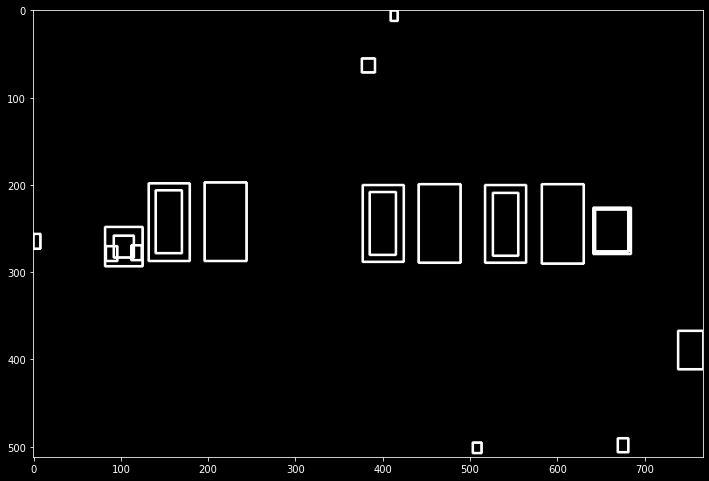

In [ ]:
# Select Candidates by Char Size
# bounding rect 중 번호판만 추출
# 1) 번호판의 글자의 크기를 가정해놓고 번호판의 숫자의 비율에 해당되는 숫자값 지정

MIN_AREA = 80
# 번호판 숫자의 윤곽선에 bounding rect의 최소 넚이 80 지정

MIN_WIDTH, MIN_HEIGHT = 2, 8
# bounding rect의 최소 너비와 높이 2, 8 지정

MIN_RATIO, MAX_RATIO = 0.25, 1.0
# bounding rect의 비율, 가로 대비 세로 비율의 MIN & MAX 값 0.25, 1.0 지정

possible_contours = []
# 가능한 (MIN_AREA, MIN_WIDTH, MIN_HEIGHT, MIN_RATIO, MAX_RATIO) 이것들을 저장

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    # contours_dict의 list에 너비, 가로 세로 비율을 계산
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        # 아까 지정해둔 조건을 비교하면서 번호판인 확률이 높은 것들을 추출 -> 나중에 index로 연산하기 때문
        # 각 윤곽선의 idx값을 매겨놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼냄
        
        d['idx'] = cnt
        # possible_contours에 저장할때, index를 같이 저장
        
        cnt += 1
        
        possible_contours.append(d)
        # 번호판인 확률이 높은 것들을 추출하여 다시 possible_contours에 저장 
        
        
        
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

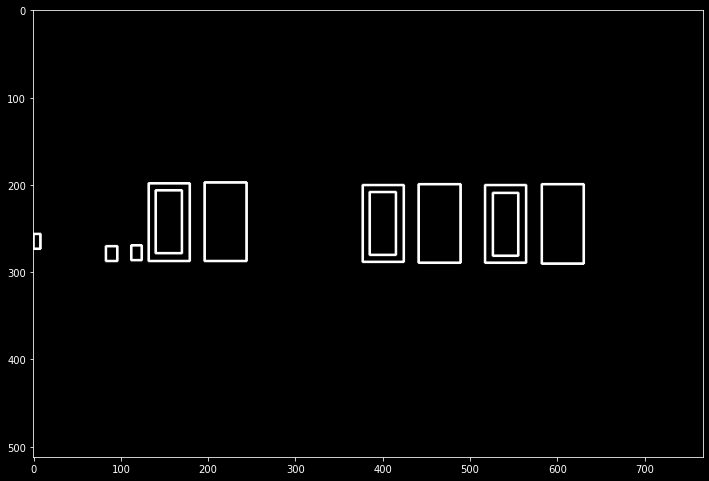

In [ ]:
# Select Candidates by Arrangement of Contours

# possible_contours의 정렬방식을 보고 번호판 후보들을 추려냄
# [번호판] 규칙적인 숫자가 연속적으로, 순차적으로 정렬, 배열되어 있음

MAX_DIAG_MULTIPLYER = 5 # 5, 
# MAX_DIAG_MULTIPLYER countour 사이의 길이를 제한, 측정할 contour의 대각선 길이(diag_length)의 대각선 중심
# 첫번째 contour랑 후보군 contour의 길이가 첫번째 contour의 diag_length의 다섯배 안에 있어야 한다.

MAX_ANGLE_DIFF = 12.0 # 12.0
# 첫번째 contour랑 두번째 contour의 중심을 이었을때, 그리는 직각 삼각형의 cos값 세타의 최대값
# 각이 너무 벌어져있으면 번호판 후보군에 들지 못함

MAX_AREA_DIFF = 0.5 # 0.5
# 첫번째 contour랑 두번째 contour의 면적 차이가 너무 많이 나면 인정하지 않음

MAX_WIDTH_DIFF = 0.8
# 첫번째 contour랑 두번째 contour의 너비 차이가 너무 많이 나면 인정하지 않음

MAX_HEIGHT_DIFF = 0.2
# 첫번째 contour랑 두번째 contour의 높아 차이가 너무 많이 나면 인정하지 않음

MIN_N_MATCHED = 3 # 3
# 후보군들의 예와 함께 번호판같은 것들을 추출하였을때, 위의 조건을 충족한 것들이 3개 이하일때,
# 번호판으로 인식하지 않음, 최소 3개 이상 조건 충족시 인정

# 여섯개의 파라미터를 지정, 

def find_chars(contour_list):
    # find_chars 함수를 지정, 함수를 지정하는 이유는 나중에 Recursive (재귀적) 방식으로 번호판 후보군을 찾음
    # 재귀함수로 반복적으로 찾음, 
    
    matched_result_idx = []
    # 최종적으로 남는 결과물의 index값들을 저장, matched_result_idx의 최종 index값들을 저장
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                # for문을 2번 돌면서 contour d1과 d2를 비교
                # d1 index와 d2의 index가 같으면, 같은 contour기 때문에 
                # 그 contour는 비교할 필요 없음 -> continue로 넘김
                

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            # dx, dy는 대각선의 중심부

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            # diagonal_length1는 d1의 대각선 길이

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            # d의 거기를 구하기 위해 np.linalg.norm를 이용하여 벡터 a와 벡터 b 사이(contour)의 거리를 구함
            
            if dx == 0:                
                angle_diff = 90
                # dx가 0인것은 가로 차이가 0인것으로 d2가 d1과 똑같은 x값을 가졌다는 뜻으로 
                # 각도가 90도가 차이난다는 뜻으로 번호판일 확률이 적음
                # dx가 0이 되버리면 분모가 0이 되버리기 때문에 일부로 angle_diff을 90으로 예외처리함
                
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
                # np.arctan 아크탄젠트 값을 구한다 (라디안) 
                # np.degrees를 사용하여 라디안을 도(36.5도 같은)로 변경
                
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            # area_diff 면적의 비율
            
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            # width_diff 너비의 비율
            
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            # height_diff 높이의 비율
            

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                # 아까 설정한 파라미터의 기준에 맞는 것들만 matched_contours_idx에 담음, index만
                

        # append this contour
        matched_contours_idx.append(d1['idx'])
        # 다 append하면 번호판의 후보군들이 생성됨
        

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            # 번호판 후보군들의 길이, 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확률이 낮음
            # 한국 번호판은 총 6~7자리이기 때문에 번호판 후보군에서 제외
            

        matched_result_idx.append(matched_contours_idx)
        # 위 사항을 통과했으면 번호판의 후보군을 matched_result_idx에 넣어줌
        

        unmatched_contour_idx = []
        # matched_result_idx가 아닌 것들도 다시 확인하는 과정
        
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
                # matched_contours_id가 아닌 것들 (d4['idx'])을 unmatched_contour_idx에 넣음
                

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        # unmatched_contour에서 np.take 함수를 통해서 추출, np.take a에서 idx와 같은 인덱스의 값만 추출
        
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        # find_chars 함수에 넣어서 재귀함수로 돌려버림, recursive하게 돌려버림
        # 그에 따른 list인 recursive_contour_list, 재귀함수 돌려서 살아남은 것들.. 강력하네,,
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            # 재귀함수로 탈탈털었는데 살아남은 아이들은 다시 matched_result_idx.append에 저장됨
            # 여기서 find_chars 함수가 끝남

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

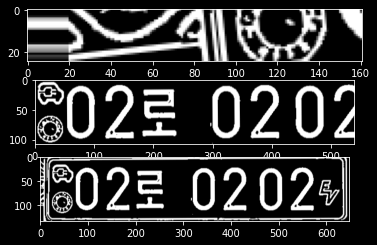

In [ ]:
# Rotate Plate Images

# Affine Transform을 사용하여 삐뚤어진 이미지를 바로 돌려놓음

PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    # matched_result를 루프를 돌면서 
    
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # x방향에 순차적으로 정렬
    

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    # plate의 센터 x, 센터 y 좌표를 구함
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    # plate의 너비
    
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # plate의 높이
    
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    # 번호판 어쩌고 저쩌고 note 참고
    
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    # cv2.getRotationMatrix2D()로 getRotationMatrix를 구함
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    # getRotationMatrix를 통해 삐뚤어진 이미지를 cv2.warpAffine()를 사용하여 똑바로 돌릴 수 있음
    
    img_cropped = cv2.getRectSubPix(
        #cv2.getRectSubPix()를 사용하여 회전된 이미지에서 원하는 부분만 잘라냄
        
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

높삐、


뭄02로 0202

02로0202
큭욜02로 0202꽝

02로0202


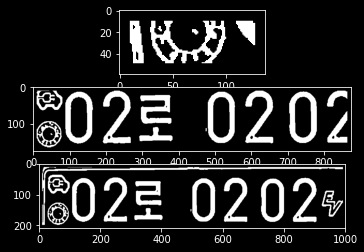

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img  = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _  = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    print(chars)
    result_chars = ''
    has_digit = False
    for c in chars:
        #if ord(c) == ord('로') or c.isdigit():
        #if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
        if ord(c) == ord('가') or ord(c) == ord('나') or ord(c) == ord('다') or ord(c) == ord('라')or ord(c) == ord('마') or ord(c) ==  ord('거') or ord(c) == ord('너') or ord(c) == ord('더') or ord(c) == ord('러')or ord(c) == ord('머') or ord(c) == ord('버') or ord(c) == ord('서') or ord(c) == ord('어') or ord(c) == ord('저')or ord(c) == ord('고') or ord(c) == ord('노') or ord(c) == ord('도') or ord(c) == ord('로') or ord(c) == ord('모')or ord(c) == ord('보') or ord(c) == ord('소') or ord(c) == ord('오') or ord(c) == ord('조') or ord(c) == ord('구')or ord(c) == ord('누') or ord(c) == ord('두') or ord(c) == ord('무') or ord(c) == ord('부') or ord(c) == ord('수')or ord(c) == ord('우') or ord(c) == ord('주') or ord(c) == ord('아') or ord(c) == ord('바') or ord(c) == ord('사')or ord(c) == ord('자') or ord(c) == ord('배') or ord(c) == ord('하') or ord(c) == ord('허') or ord(c) == ord('호') or c.isdigit(): 
            if c.isdigit():
                has_digit = True
            result_chars += c
   
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

02로0202


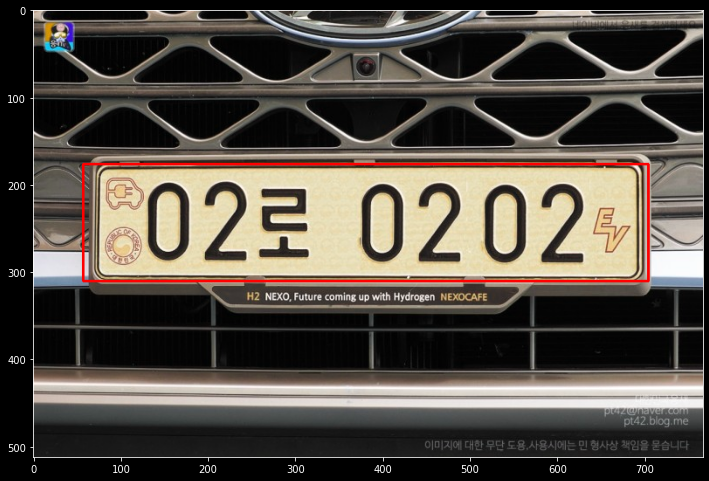

In [ ]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)